In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
print(os.listdir("../content"))

['.config', 'YOLOCar', '.ipynb_checkpoints', 'sample_data']


In [3]:
import tensorflow as tf
from keras import backend as K
from keras.models import load_model, Model
import PIL
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [4]:
import colorsys
import imghdr
import os
import random
from keras import backend as K

import numpy as np
from PIL import Image, ImageDraw, ImageFont

def read_classes(classes_path):
    with open(classes_path) as f:
        class_names = f.readlines()
    class_names = [c.strip() for c in class_names]
    return class_names

def read_anchors(anchors_path):
    with open(anchors_path) as f:
        anchors = f.readline()
        anchors = [float(x) for x in anchors.split(',')]
        anchors = np.array(anchors).reshape(-1, 2)
    return anchors
def generate_colors(class_names):
    hsv_tuples = [(x / len(class_names), 1., 1.) for x in range(len(class_names))]
    colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
    colors = list(map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)), colors))
    random.seed(10101)  # Fixed seed for consistent colors across runs.
    random.shuffle(colors)  # Shuffle colors to decorrelate adjacent classes.
    random.seed(None)  # Reset seed to default.
    return colors

def scale_boxes(boxes, image_shape):
    height = image_shape[0]
    width = image_shape[1]
    image_dims = K.stack([height, width, height, width])
    image_dims = K.reshape(image_dims, [1, 4])
    boxes = boxes * image_dims
    return boxes
def preprocess_image(img_path, model_image_size):
    image_type = imghdr.what(img_path)
    image = Image.open(img_path)
    resized_image = image.resize(tuple(reversed(model_image_size)), Image.BICUBIC)
    image_data = np.array(resized_image, dtype='float32')
    image_data /= 255.
    image_data = np.expand_dims(image_data, 0)  # Add batch dimension.
    return image, image_data

def draw_boxes(image, out_scores, out_boxes, out_classes, class_names, colors):
    
    font = ImageFont.truetype(font='/content/YOLOCar/content/font/FiraMono-Medium.otf',size=np.floor(3e-2 * image.size[1] + 0.5).astype('int32'))
    thickness = (image.size[0] + image.size[1]) // 300

    for i, c in reversed(list(enumerate(out_classes))):
        predicted_class = class_names[c]
        box = out_boxes[i]
        score = out_scores[i]

        label = '{} {:.2f}'.format(predicted_class, score)

        draw = ImageDraw.Draw(image)
        label_size = draw.textsize(label, font)
        top, left, bottom, right = box
        top = max(0, np.floor(top + 0.5).astype('int32'))
        left = max(0, np.floor(left + 0.5).astype('int32'))
        bottom = min(image.size[1], np.floor(bottom + 0.5).astype('int32'))
        right = min(image.size[0], np.floor(right + 0.5).astype('int32'))
        print(label, (left, top), (right, bottom))

        if top - label_size[1] >= 0:
            text_origin = np.array([left, top - label_size[1]])
        else:
            text_origin = np.array([left, top + 1])

        # My kingdom for a good redistributable image drawing library.
        for i in range(thickness):
            draw.rectangle([left + i, top + i, right - i, bottom - i], outline=colors[c])
        draw.rectangle([tuple(text_origin), tuple(text_origin + label_size)], fill=colors[c])
        draw.text(text_origin, label, fill=(0, 0, 0), font=font)
        del draw
def yolo_head(feats, anchors, num_classes):
    
    num_anchors = len(anchors)
    anchors_tensor = K.reshape(K.variable(anchors), [1, 1, 1, num_anchors, 2])

    # Dynamic implementation of conv dims for fully convolutional model.
    conv_dims = K.shape(feats)[1:3]  # assuming channels last
    # In YOLO the height index is the inner most iteration.
    conv_height_index = K.arange(0, stop=conv_dims[0])
    conv_width_index = K.arange(0, stop=conv_dims[1])
    conv_height_index = K.tile(conv_height_index, [conv_dims[1]])

    # TODO: Repeat_elements and tf.split doesn't support dynamic splits.
    # conv_width_index = K.repeat_elements(conv_width_index, conv_dims[1], axis=0)
    conv_width_index = K.tile(K.expand_dims(conv_width_index, 0), [conv_dims[0], 1])
    conv_width_index = K.flatten(K.transpose(conv_width_index))
    conv_index = K.transpose(K.stack([conv_height_index, conv_width_index]))
    conv_index = K.reshape(conv_index, [1, conv_dims[0], conv_dims[1], 1, 2])
    conv_index = K.cast(conv_index, K.dtype(feats))
    
    feats = K.reshape(feats, [-1, conv_dims[0], conv_dims[1], num_anchors, num_classes + 5])
    conv_dims = K.cast(K.reshape(conv_dims, [1, 1, 1, 1, 2]), K.dtype(feats))


    box_confidence = K.sigmoid(feats[..., 4:5])
    box_xy = K.sigmoid(feats[..., :2])
    box_wh = K.exp(feats[..., 2:4])
    box_class_probs = K.softmax(feats[..., 5:])

    box_xy = (box_xy + conv_index) / conv_dims
    box_wh = box_wh * anchors_tensor / conv_dims

    return box_confidence, box_xy, box_wh, box_class_probs
def yolo_boxes_to_corners(box_xy, box_wh):
    box_mins = box_xy - (box_wh / 2.)
    box_maxes = box_xy + (box_wh / 2.)

    return K.concatenate([
        box_mins[..., 1:2],  # y_min
        box_mins[..., 0:1],  # x_min
        box_maxes[..., 1:2],  # y_max
        box_maxes[..., 0:1]  # x_max
    ])
        


In [5]:
!pip install h5py==2.10.0 --force-reinstall

  Using cached h5py-2.10.0-cp37-cp37m-manylinux1_x86_64.whl (2.9 MB)
  Using cached numpy-1.21.5-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (15.7 MB)
  Using cached six-1.16.0-py2.py3-none-any.whl (11 kB)
  Attempting uninstall: six
    Found existing installation: six 1.16.0
    Uninstalling six-1.16.0:
      Successfully uninstalled six-1.16.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.5
    Uninstalling numpy-1.21.5:
      Successfully uninstalled numpy-1.21.5
  Attempting uninstall: h5py
    Found existing installation: h5py 2.10.0
    Uninstalling h5py-2.10.0:
      Successfully uninstalled h5py-2.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lucid 0.3.10 requires umap-learn, which is not installed.
tensorflow 1.15.2 requires gast==0.2.2, but you have gast 0.4.0 which is incompatible.
lucid 0.3.10 requir

In [6]:
yolo_model = load_model("/content/YOLOCar/content/model_data/yolo.h5")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.




/tensorflow-1.15.2/python3.7/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [7]:
yolo_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 608, 608, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 608, 608, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 608, 608, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 608, 608, 32) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [8]:
def yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = .6):
   
    box_scores = box_confidence*box_class_probs
    box_classes = K.argmax(box_scores, axis=-1)
    box_class_scores = K.max(box_scores, axis=-1)
    filtering_mask = box_class_scores>threshold

    scores = tf.boolean_mask(box_class_scores,filtering_mask,name="scores")
    boxes = tf.boolean_mask(boxes, filtering_mask, name='boxes')
    classes = tf.boolean_mask(box_classes,filtering_mask, name="boxes")
    return scores, boxes, classes

In [9]:
def yolo_non_max_suppression(scores, boxes, classes, max_boxes = 10, iou_threshold = 0.5):

    max_boxes_tensor = K.variable(max_boxes, dtype='int32')     # tensor to be used in tf.image.non_max_suppression()
    K.get_session().run(tf.variables_initializer([max_boxes_tensor])) # initialize variable max_boxes_tensor
    nms_indices = tf.image.non_max_suppression(boxes,scores,max_boxes,iou_threshold)

    scores = K.gather(scores, nms_indices)
    boxes = K.gather(boxes,nms_indices)
    classes = K.gather(classes,nms_indices)
    return scores, boxes, classes

In [10]:
def yolo_eval(yolo_outputs, image_shape = (720., 1280.), max_boxes=10, score_threshold=.6, iou_threshold=.5):
     
    box_confidence, box_xy, box_wh, box_class_probs = yolo_outputs
    boxes = yolo_boxes_to_corners(box_xy, box_wh)
    scores, boxes, classes = yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = 0.5)
    boxes = scale_boxes(boxes, image_shape)
    scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes)
    

    
    return scores, boxes, classes


In [11]:
sess = K.get_session()

In [12]:
class_names = read_classes("/content/YOLOCar/content/model_data/coco_classes.txt")
anchors = read_anchors("/content/YOLOCar/content/model_data/yolo_anchors.txt")
image_shape = (720., 1280.)  

In [13]:
yolo_outputs = yolo_head(yolo_model.output, anchors, len(class_names))

In [14]:
scores, boxes, classes = yolo_eval(yolo_outputs, image_shape)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [15]:
def predict(sess, image_file):

    image, image_data = preprocess_image("/content/YOLOCar/content/images/" + image_file, model_image_size = (608, 608))
    out_scores, out_boxes, out_classes = sess.run([scores, boxes, classes], feed_dict={yolo_model.input: image_data, K.learning_phase(): 0})

    print('Found {} boxes for {}'.format(len(out_boxes), image_file))
    colors = generate_colors(class_names)

    draw_boxes(image, out_scores, out_boxes, out_classes, class_names, colors)
    
    plt.imshow(image)
    
    return out_scores, out_boxes, out_classes

Found 7 boxes for test4.jpg
person 0.61 (103, 306) (148, 401)
car 0.62 (346, 288) (425, 337)
car 0.71 (458, 311) (534, 383)
car 0.71 (631, 352) (733, 446)
car 0.74 (882, 381) (1077, 505)
car 0.83 (794, 455) (1031, 622)
car 0.85 (540, 450) (737, 657)


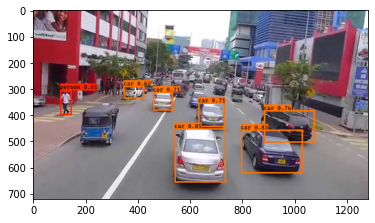

In [16]:
out_scores, out_boxes, out_classes = predict(sess, "test4.jpg")

Found 10 boxes for car.jpg
cell phone 0.72 (408, 156) (460, 241)
cell phone 0.74 (378, 376) (423, 474)
cell phone 0.74 (926, 160) (988, 250)
cell phone 0.75 (1064, 382) (1000, 472)
cell phone 0.76 (771, 483) (817, 596)
cell phone 0.78 (518, 165) (575, 243)
cell phone 0.79 (439, 496) (485, 594)
cell phone 0.80 (1076, 491) (1000, 587)
cell phone 0.81 (240, 474) (288, 571)
cell phone 0.83 (1186, 378) (1000, 470)


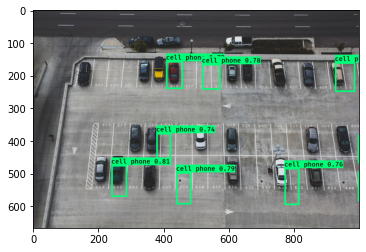

In [17]:
out_scores, out_boxes, out_classes = predict(sess, "car.jpg")

Found 4 boxes for car2.jpg
car 0.72 (382, 295) (450, 322)
car 0.80 (127, 307) (343, 417)
car 0.87 (335, 317) (750, 507)
car 0.88 (777, 302) (750, 563)


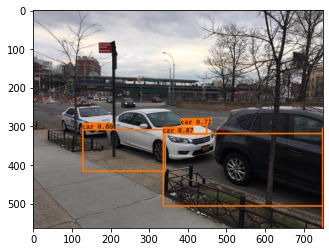

In [18]:
out_scores, out_boxes, out_classes = predict(sess, "car2.jpg")

Found 10 boxes for car3.jpg
car 0.65 (487, 112) (550, 165)
car 0.67 (0, 88) (108, 167)
car 0.67 (544, 107) (643, 173)
car 0.70 (389, 104) (493, 163)
truck 0.72 (1029, 121) (1246, 276)
car 0.77 (663, 126) (760, 174)
car 0.81 (37, 303) (598, 620)
car 0.81 (578, 274) (1272, 695)
car 0.88 (834, 195) (1063, 340)
car 0.89 (522, 233) (854, 419)


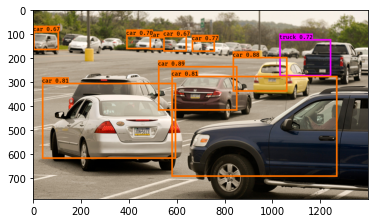

In [19]:
out_scores, out_boxes, out_classes = predict(sess, "car3.jpg")

Found 3 boxes for car4.jpg
car 0.59 (414, 271) (710, 331)
car 0.65 (190, 253) (316, 286)
car 0.80 (614, 247) (1028, 382)


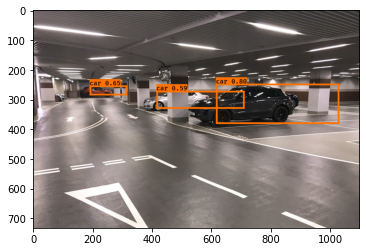

In [24]:
out_scores, out_boxes, out_classes = predict(sess, "car4.jpg")

In [20]:
!pip install opencv-python

In [21]:
!pip install tensorflow-object-detection-api

     |████████████████████████████████| 577 kB 5.1 MB/s 
     |████████████████████████████████| 54 kB 2.0 MB/s 
     |████████████████████████████████| 138 kB 8.6 MB/s 
     |████████████████████████████████| 54 kB 1.7 MB/s 
     |████████████████████████████████| 63 kB 578 kB/s 
     |████████████████████████████████| 3.6 MB 38.8 MB/s 
  Created wheel for tensorflow-object-detection-api: filename=tensorflow_object_detection_api-0.1.1-py3-none-any.whl size=844512 sha256=9d464c11f0eee6192c79d689331cc2cf14b738619d3c6ca5fd6c4cebc10238a1
  Stored in directory: /root/.cache/pip/wheels/71/7e/a2/461ab817fbaef68ec9cc60df16d3669d1285f032e4c98179bf
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=328f5180fca55d3bd31130e9abec5f93fdf726cde842c420d24610078fa1ee52
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built tensorflow-object-detection-api gast
  Attempting uninstall: urllib3
    Found ex

In [22]:
%matplotlib inline

In [23]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
import pathlib
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import display
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util
 
while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
 
def load_model(model_name):
  base_url = 'http://download.tensorflow.org/models/object_detection/'
  model_file = model_name + '.tar.gz'
  model_dir = tf.keras.utils.get_file(
    fname=model_name, 
    origin=base_url + model_file,
    untar=True)
 
  model_dir = pathlib.Path(model_dir)/"saved_model"
  model = tf.saved_model.load(str(model_dir), None)
  return model
 
PATH_TO_LABELS = 'models/research/object_detection/data/mscoco_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)
 
model_name = 'ssd_inception_v2_coco_2017_11_17'
detection_model = load_model(model_name)
 
def run_inference_for_single_image(model, image):
  image = np.asarray(image)
  # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
  input_tensor = tf.convert_to_tensor(image)
  # The model expects a batch of images, so add an axis with `tf.newaxis`.
  input_tensor = input_tensor[tf.newaxis,...]
 
  # Run inference
  model_fn = model.signatures['serving_default']
  output_dict = model_fn(input_tensor)
 
  # All outputs are batches tensors.
  # Convert to numpy arrays, and take index [0] to remove the batch dimension.
  # We're only interested in the first num_detections.
  num_detections = int(output_dict.pop('num_detections'))
  output_dict = {key:value[0, :num_detections].numpy() 
                 for key,value in output_dict.items()}
  output_dict['num_detections'] = num_detections
 
  # detection_classes should be ints.
  output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
    
  # Handle models with masks:
  if 'detection_masks' in output_dict:
    # Reframe the the bbox mask to the image size.
    detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
              output_dict['detection_masks'], output_dict['detection_boxes'],
               image.shape[0], image.shape[1])      
    detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                       tf.uint8)
    output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()

NotFoundError: ignored

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [ ]:
def show_inference(model, frame):
  #take the frame from webcam feed and convert that to array
  image_np = np.array(frame)
  # Actual detection.
     
  output_dict = run_inference_for_single_image(model, image_np)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks_reframed', None),
      use_normalized_coordinates=True,
      line_thickness=5)
 
  return(image_np)

In [ ]:
#Now we open the webcam and start detecting objects
import cv2
video_capture = cv2.VideoCapture(0)
while True:
    # Capture frame-by-frame
    re,frame = video_capture.read()
    Imagenp=show_inference(detection_model, frame)
    cv2.imshow('object detection', cv2.resize(Imagenp, (800,600)))
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
video_capture.release()
cv2.destroyAllWindows()
